In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
import keras
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
import os 
import pandas as pd
import plotly.graph_objs as go
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
import glob

In [7]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count

In [8]:
train_dir ="/content/drive/MyDrive/DatasetCopy/train"
test_dir="/content/drive/MyDrive/DatasetCopy/valid"


In [9]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

6 Classes
4200 Train images
1784 Test images


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [12]:
img_width,img_height =224,224
input_shape=(img_width,img_height,3)
batch_size =32
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(img_width,img_height),batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(img_width,img_height),batch_size=batch_size)

Found 4200 images belonging to 6 classes.
Found 1784 images belonging to 6 classes.


In [16]:
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.models import Model
import keras
from keras import optimizers
model_finetuned = Sequential()

model_finetuned.add(MobileNet(weights='imagenet'))
model_finetuned.add(BatchNormalization())
model_finetuned.add(Dense(128, activation="relu"))
model_finetuned.add(Dense(6, activation="softmax"))
for layer in model_finetuned.layers[0].layers:
  if layer.__class__.__name__=="BatchNormalization":
    layer.trainable=True
  else:
    layer.trainable=False
model_finetuned.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
model_finetuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1000)             4253864   
 nal)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 1000)             4000      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 128)               128128    
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4,386,766
Trainable params: 152,790
Non-trainable params: 4,233,976
_________________________________________________________________


In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
validation_generator = train_datagen.flow_from_directory(
                       test_dir, # same directory as training data
                       target_size=(img_height, img_width),
                       batch_size=batch_size)

history_1 = model_finetuned.fit(train_generator,                                    
                                  steps_per_epoch=None, 
                                  epochs=15,validation_data=validation_generator,validation_steps=None
                                  ,verbose=1,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],use_multiprocessing=False,
               shuffle=True)

Found 1784 images belonging to 6 classes.
Epoch 1/15
132/132 [==============================] - 1320s 10s/step - loss: 0.6201 - accuracy: 0.8174 - val_loss: 1.3754 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 2/15
132/132 [==============================] - 720s 5s/step - loss: 0.1870 - accuracy: 0.9336 - val_loss: 0.9590 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 3/15
132/132 [==============================] - 731s 6s/step - loss: 0.1387 - accuracy: 0.9533 - val_loss: 0.4625 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 4/15
132/132 [==============================] - 733s 6s/step - loss: 0.0988 - accuracy: 0.9617 - val_loss: 0.1681 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 5/15
132/132 [==============================] - 724s 5s/step - loss: 0.0863 - accuracy: 0.9698 - val_loss: 0.1200 - val_accuracy: 0.9585 - lr: 0.0010
Epoch 6/15
 84/132 [==================>...........] - ETA: 4:07 - loss: 0.0828 - accuracy: 0.9721

KeyboardInterrupt: ignored

In [51]:
from keras.models import load_model
model_finetuned.save('plantdiseasemobilenet8epoch.h5')

[[1.4439907e-03 1.3054679e-02 9.8303533e-01 9.6069329e-04 3.1163427e-04
  1.1937222e-03]]


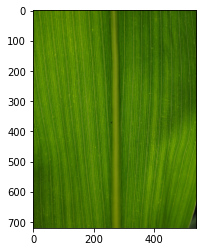

In [49]:
classes=list(train_generator.class_indices.keys())
import numpy as np
import matplotlib.pyplot as plt
# Pre-Processing test data same as train data.
img_width=224
img_height=224
#model_finetuned.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
path= '/content/drive/MyDrive/DatasetCopy/test/corn-leaf-592581_960_720.jpg'

result = model_finetuned.predict([prepare(path)])

disease=image.load_img(path)
plt.imshow(disease)
print(result)

In [50]:
import numpy as np
classresult=np.argmax(result,axis=1)
print(classes[classresult[0]])

Corn(maize) healthy


In [ ]:
import tensorflow as tf
keras_model = tf.keras.models.load_model("plantdiseasemobilenet8epoch.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)

In [ ]:
model = converter.convert()
file = open( 'outputmobilenetof8epoch.tflite' , 'wb' ) 
file.write( model )

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="outputmobilenetof8epoch.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print("")
print(output_details)

In [ ]:
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
    
    
input_data = [prepare('/kaggle/input/new-plant-diseases-dataset/test/test/TomatoYellowCurlVirus6.JPG')]

In [ ]:
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], input_data[0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

In [ ]:
classresult=np.argmax(output_data,axis=1)
print(classes[classresult[0]])

In [52]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

print(history_1.history.keys())

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored